# Tarea 2 - MAN3160



**Profesor**: Denis Parra

**Ayudante**: Álvaro Labarca.


En esta tarea, utilizaremos la librería Implicit vista en los tutoriales del curso para comparar el rendimiento de los modelos ALS y BPR.
Para realizar la tarea, deberán leer y ejecutar todas las celdas del notebook y completar/responder las actividades que serán dadas.

## Descarga del dataset

Al igual que en la tarea 1 y los tutoriales del curso, vamos a descargar el dataset [MovieLens-100k](https://grouplens.org/).

Podemos descargar el dataset directamente con el comando wget.

In [1]:
# !pip install wget
# !pip install zipfile36
# !pip3 install implicit --upgrade
# !python -m wget http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [2]:
# import zipfile
# with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
#     zip_ref.extractall(".")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import implicit
import scipy.sparse as sparse
import time

In [4]:
train_dir = "ml-100k/u3.base"
test_dir = "ml-100k/u3.test"

In [5]:
import pandas as pd

train_file = pd.read_csv(train_dir, sep='\t', names = ['userid', 'itemid', 'rating', 'timestamp'], header=None)

train_file.head()

,userid,itemid,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,6,5,887431973


In [6]:
info_cols = [ 'movieid', 'title', 'release_date', 'video_release_date', 'IMDb_URL', \
              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', \
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', \
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' ]

pd.options.display.max_columns = None

info_file = pd.read_csv('ml-100k/u.item', sep='|', index_col = 0, names = info_cols, header=None, encoding='latin-1')

info_file.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


## Funciones

In [7]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

In [8]:
def evaluate_model(model, n):
    mean_map = 0.
    mean_ndcg = 0.
    for u in user_items_test.keys():
        rec = model.recommend(user_ids[u], user_item_matrix[user_ids[u]], n)[0]
        rec = [itemset[r] for r in rec]
        rel_vector = [np.isin(rec, user_items_test[u], assume_unique=True).astype(int)]
        mean_map += mean_average_precision(rel_vector)
        mean_ndcg += ndcg_at_k(rel_vector, n)

    mean_map /= len(user_items_test)
    mean_ndcg /= len(user_items_test)

    return mean_map, mean_ndcg

In [9]:
def show_recommendations(model, user, n):
    recommendations = model.recommend(userid=user_ids[user], user_items=user_item_matrix[user_ids[user]], N=n)
    return df_items.loc[recommendations[0]]['title']

# Actividades

### Actividad 1: Preparación del dataset

Prepare el dataset para que este pueda ser utilizado por los algoritmos de la librería Implicit. (Puede utilizar de base los tutoriales del curso), hasta generar la matriz user_items en formato csr. Puede importar/utilizar cualquier librería adicional que desée.

#### Respuesta:

Ingrese su respuesta en código a continuación. Puede utilizar todas las celdas de código que estime necesaria. Al finalizar, añada una celda de texto (Markdown en Jupyter) explicando qué contiene la matriz csr generada, qué representan sus columnas, sus filas y sus celdas internas.

In [10]:
# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
train_file.rating = [1 if x >= 3 else 0 for x in train_file.rating ]

In [11]:
train_file.head()

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,3,1,878542960
3,1,4,1,876893119
4,1,6,1,887431973


In [12]:
# Cargamos el dataset con los items
dir_train = 'ml-100k'

df_items = pd.read_csv(f'{dir_train}/u.item',
                        sep='|',
                        index_col=0,
                        names = info_cols,
                        header=None,
                        encoding='latin-1')
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [13]:
# Cargamos el dataset de testing
df_test = pd.read_csv(f'{dir_train}/u2.test',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0)
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []

    user_items_test[row[1]].append(row[2])

In [14]:
user_items = {}
itemset = set()

for row in train_file.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []

    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)

user_item_matrix = sparse.csr_matrix(sparse_matrix)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
items_ids = {key: i for i, key in enumerate(itemset)}

In [15]:
user_item_matrix.toarray()

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

La matriz generada `user_item_matrix` al solo hacer uso de las columnas userid y itemid,  genera una matriz dispersa en la que cada fila representa un usuario y cada columna representa un ítem. Los valores en la matriz indican si un usuario ha interactuado con un ítem específico. Si el valor en la posición **(i, j)** es *1*, significa que el usuario **i** ha interactuado con el ítem **j**, y si es *0*, significa que no ha habido interacción.

### Actividad 2: Entrenamiento de modelo ALS

Entrene el modelo ALS con el set de entrenamiento y realice un estudio de hiperparámetros sobre al menos 2 hiperparámetros del modelo. Despliegue el gráfico sobre la variación del rendimiento (en base a las métricas nDCG y MAP) según el valor del hiperparámetro y explique explícitamente la forma de los gráficos, las conclusiones obtenidas de ellos y la mejor combinación de hiperparámetros en su opinión. Registre y haga un gráfico del tiempo de entrenamiento de cada método. Se recomienda usar la librería _time_ para esto.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de código con sus conclusiones y respuestas.

In [16]:
%%time
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares()
model_als.fit(user_item_matrix)

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 2.27 s, sys: 2.99 s, total: 5.25 s
Wall time: 457 ms


In [17]:
factores = [i*5 for i in range(1, 15)]
reg_fac = [0.001, 0.01, 0.1]

map_f = []
ndcg_f = []

map_rg = []
ndcg_rg = []

for f in factores:
    model_als = implicit.als.AlternatingLeastSquares(factors=f)
    model_als.fit(user_item_matrix)
    mmap, ndcg = evaluate_model(model_als, 10)
    map_f.append(mmap)
    ndcg_f.append(ndcg)
    
for rg in reg_fac:
    model_als = implicit.als.AlternatingLeastSquares(regularization=rg)
    model_als.fit(user_item_matrix)
    mmap, ndcg = evaluate_model(model_als, 10)
    map_rg.append(mmap)
    ndcg_rg.append(ndcg)


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [22]:
# Definir los valores de factores y regularización
factores = [i*5 for i in range(1, 15)]
reg_fac = [0.001, 0.01, 0.1]

map_f = []
ndcg_f = []

map_rg = []
ndcg_rg = []

# Listas para almacenar los tiempos de entrenamiento
tiempos_factores = []
tiempos_regularizacion = []

# Entrenar y medir el tiempo para diferentes valores de factores
for f in factores:
    model_als = implicit.als.AlternatingLeastSquares(factors=f)
    start_time = time.time()
    model_als.fit(user_item_matrix)
    end_time = time.time()
    tiempo_entrenamiento = end_time - start_time
    tiempos_factores.append(tiempo_entrenamiento)

    # Guardar metricas 
    mmap, ndcg = evaluate_model(model_als, 10)
    map_f.append(mmap)
    ndcg_f.append(ndcg)

# Entrenar y medir el tiempo para diferentes valores de regularización
for rg in reg_fac:
    model_als = implicit.als.AlternatingLeastSquares(regularization=rg)
    start_time = time.time()
    model_als.fit(user_item_matrix)
    end_time = time.time()
    tiempo_entrenamiento = end_time - start_time
    tiempos_regularizacion.append(tiempo_entrenamiento)

    # Guardar metricas
    mmap, ndcg = evaluate_model(model_als, 10)
    map_rg.append(mmap)
    ndcg_rg.append(ndcg)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

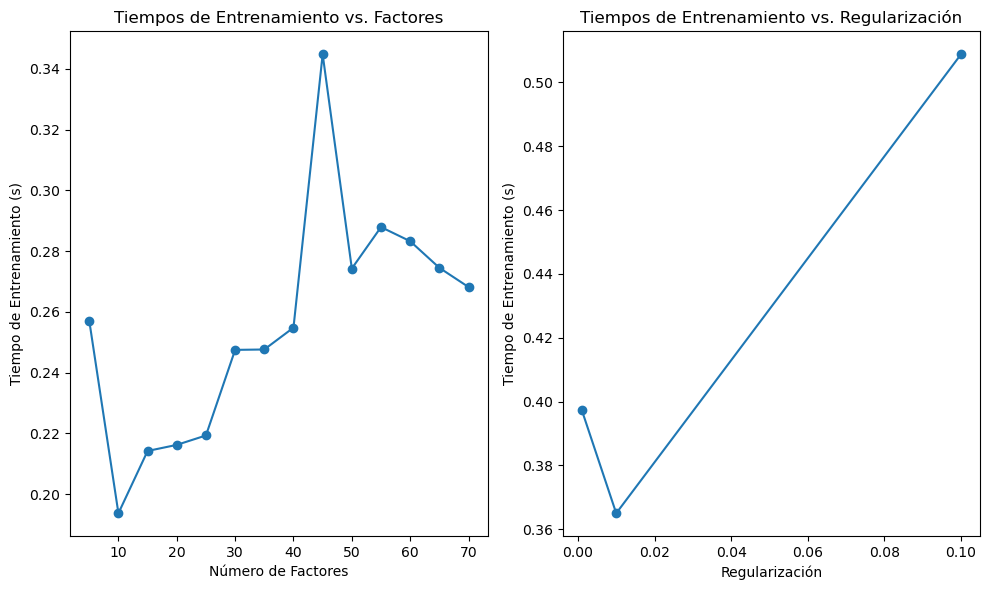

In [23]:
# Crear gráficos
plt.figure(figsize=(10, 6))

# Gráfico para tiempos de entrenamiento vs. factores
plt.subplot(1, 2, 1)
plt.plot(factores, tiempos_factores, marker='o')
plt.xlabel('Número de Factores')
plt.ylabel('Tiempo de Entrenamiento (s)')
plt.title('Tiempos de Entrenamiento vs. Factores')

# Gráfico para tiempos de entrenamiento vs. regularización
plt.subplot(1, 2, 2)
plt.plot(reg_fac, tiempos_regularizacion, marker='o')
plt.xlabel('Regularización')
plt.ylabel('Tiempo de Entrenamiento (s)')
plt.title('Tiempos de Entrenamiento vs. Regularización')

plt.tight_layout()
plt.show()

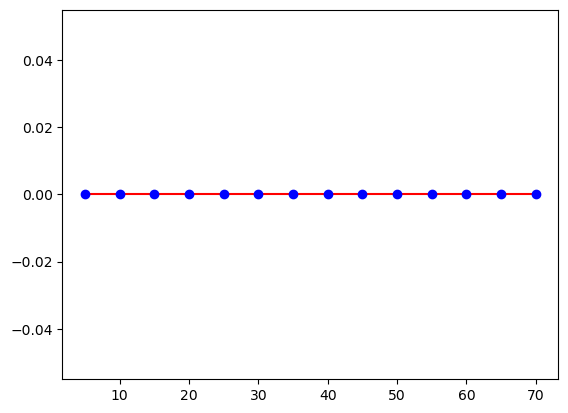

In [24]:
plt.plot(factores, map_f, 'r-')
plt.plot(factores, map_f, 'bo')
plt.show()

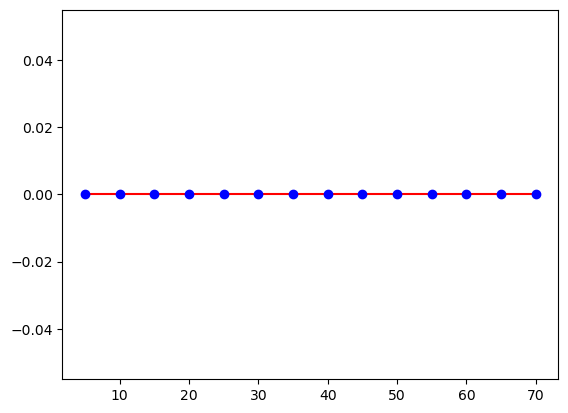

In [25]:
plt.plot(factores, ndcg_f, 'r-')
plt.plot(factores, ndcg_f, 'bo')
plt.show()

De acuerdo con los resultados:

* Por un lado, se observa que los tres diferentes cambios sobre el hiperparametro de regularización, este no presenta una relación con el tiempo de ejecución, porque a medida que este creció, los tiempos no necesariamente se redujeron debido principalmente al factor estocastico de la iniciación del descenso del gradiente.

* Adicionalmente, si se observa que a medida que aumentó el número de factores latentes en la matríz de factores, desde el punto donde estos son **50 factores**, el modelo no mejora significativamente, por lo cual, se recomendaría usar 50 factores latentes, y permitirle al modelo no sobreajustarse a los datos de entrenamiento.

### Actividad 3: Entrenamiento de modelo BPR

Repita el procedimiento de la Actividad 2 para el modelo BPR. Recuerde realizar un estudio de hiperparámetros sobre dos hiperparámetros distintos y exponer sus observaciones, elecciones como mejor combinación de hiperparámetros y realizar un análisis del tiempo de entrenamiento.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de código con sus conclusiones y respuestas.

### Actividad 4: Comparación de modelos.

Entrene modelos ALS y BPR con la combinación de hiperparámetros seleccionadas de las actividades 2 y 3. Genere una tabla exponiendo los resultados de ambos modelos al evaluarlos según nDCG@k y MAP@k proporcionadas (son libres de elegir el valor de k). Incluya también el valor del tiempo de entrenamiento empleado.

Además, implemente y agregue a su tabla los resultados usando una métrica adicional estudiada en el curso. Esta métrica puede ser programada por ustedes o usando una función de una librería externa.

Finalmente comente sobre los resultados de la tabla y concluya qué método entregó los mejores resultados para el set de datos utilizado.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de código con sus conclusiones y respuestas.

### Actividad 5: Comparación de modelos con modelo de feedback explícito.

Programe y evalúe un método de filtrado colaborativo de su elección sobre el mismo dataset. Evalúe este sistema y compare su rendimiento con los métodos de ALS y BPR entrenados en actividades anteriores. Recuerde que no todas las métricas son aplicables a sistemas de feedback explícito e implícito, por esto, seleccione al menos una métrica que permita realizar esta comparación. Justifique sus elecciones y concluya en base a los resultados dados.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de código con sus conclusiones y respuestas.